In [452]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 10, 7

from sklearn.linear_model import LinearRegression

from datetime import datetime
from typing import List
from dataclasses import dataclass

In [453]:
data = pd.read_csv("energy_consump.csv")
data.head()

,Hub,ZSP,Date,EnergyConsump,Temp1,Temp2,Temp3,Temp4,Temp5,Temp6,...,Saturday,Sunday,Temp1_South_Less,Temp2_South_Less,Temp3_South_Less,Temp4_South_Less,Temp1_South_Gr,Temp2_South_Gr,Temp3_South_Gr,Temp4_South_Gr
0,Center,FZSZOE27,2010-01-01,147487.171,-17.8,-16.9,NaN,NaN,NaN,NaN,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Center,FZSZOE27,2010-01-02,155433.800,-17.8,-20.3,NaN,NaN,NaN,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Center,FZSZOE27,2010-01-03,164140.232,-16.4,-24.0,NaN,NaN,NaN,NaN,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Center,FZSZOE27,2010-01-04,171382.848,-10.2,-15.7,NaN,NaN,NaN,NaN,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Center,FZSZOE27,2010-01-05,170188.290,-7.2,-8.8,NaN,NaN,NaN,NaN,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [454]:
time_series = pd.DataFrame()
time_series["id"] = np.arange(len(data))
time_series["cons"] = data["EnergyConsump"]
time_series["date"] = data["Date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
time_series.head()

,id,cons,date
0,0,147487.171,2010-01-01
1,1,155433.800,2010-01-02
2,2,164140.232,2010-01-03
3,3,171382.848,2010-01-04
4,4,170188.290,2010-01-05


Yearly and weekly seasonality.

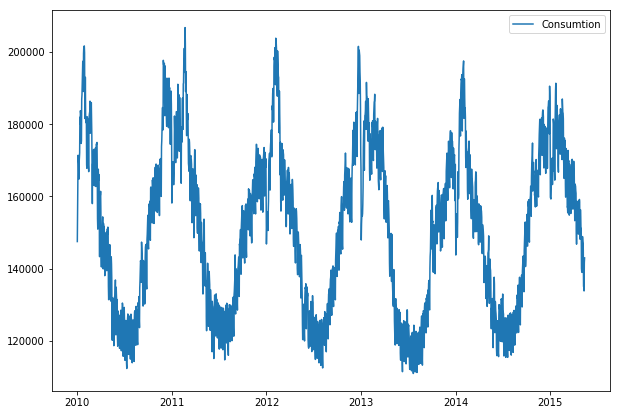

In [455]:
plt.plot(time_series.date, time_series.cons)
plt.legend(["Consumtion"])
plt.show()

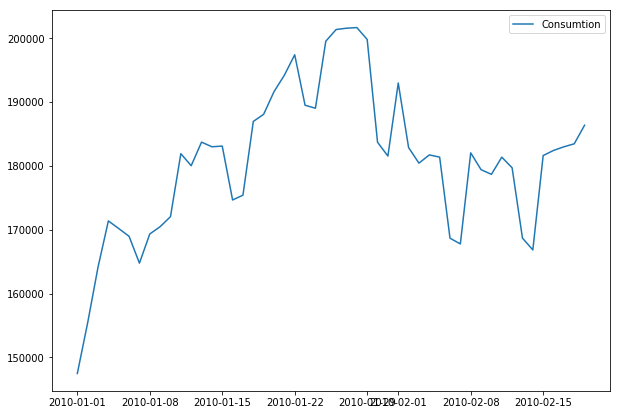

In [456]:
plt.plot(time_series.date[:50], time_series.cons[:50])
plt.legend(["Consumtion"])
plt.show()

In [457]:
year_s = 365 # yearly seasonality
week_s = 7 # weekly seasonality

In [646]:
def add_trend(data, d):
    
    pred = np.hstack((data[:1], data)).cumsum()
    
    for _ in range(d - 1):
        pred = np.hstack((pred[:1], pred)).cumsum()
        
    return pred


def add_seasonality(data, S):
    pass

In [647]:
@dataclass(init=True, repr=True)
class AR:
    
    P:int
    
    def fit(self, data):
        train, test = self.get_data(data)

        self.regression = LinearRegression()
        self.regression.fit(train, test.reshape(-1, 1))
    
    def get_data(self, data):
        train, test = list(), list()
        
        for i in range(self.P, len(data)):
            train.append(data.values[i - self.P:i])
            test.append(data[i])
            
        return np.array(train), np.array(test)

In [652]:
@dataclass(init=True, repr=True)
class ARI:
    
    d: int
    S: List
    P: int

    def fit(self, time_series):
        self.proc_data = pd.DataFrame()
        self.proc_data["id"] = np.arange(len(time_series) - self.d)
        
        self.__remove_trend(time_series)
        self.__remove_seasonality()
        
        self.ar_fit()

    def ar_fit(self):
        self.ar = AR(self.P)
        self.ar.fit(self.proc_data.data)
    
    def __remove_trend(self, time_series):
        self.proc_data["data"] = np.diff(time_series, self.d)
        
        # set nan values to mean
        self.proc_data.data = self.proc_data.data.fillna(self.proc_data.data.mean())

    def __remove_seasonality(self):
        for seas in self.S:
            self.proc_data.data = self.proc_data.id.apply(
                lambda i: self.proc_data.data[i] - self.proc_data.data[i - seas] 
                if i >= seas else self.proc_data.data[i] - self.proc_data.data[0]
            )
        
    def predict(self, n):
        extended_data = self.proc_data.data.values.copy()
        last_P_elems = self.proc_data.data.values[-self.P:]
        
        predictions = []
        
        for i in range(n):
            predicted = self.ar.regression.predict(last_P_elems.reshape(1, -1))[0]
            last_P_elems = np.concatenate((last_P_elems[1:], predicted))
            
            predictions.append(predicted[0])
            
        return np.array(predictions)

In [653]:
ari = ARI(2, [365, 7], 30)
ari.fit(time_series.cons)

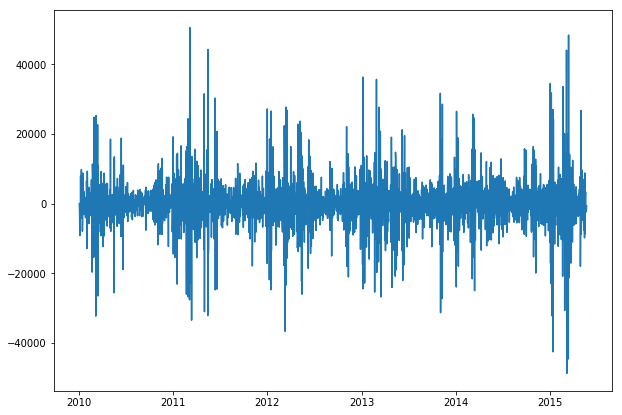

In [654]:
plt.plot(time_series.date[:len(ari.proc_data)], ari.proc_data.data);

In [655]:
pred = np.array([pred for pred in ari.predict(300)])

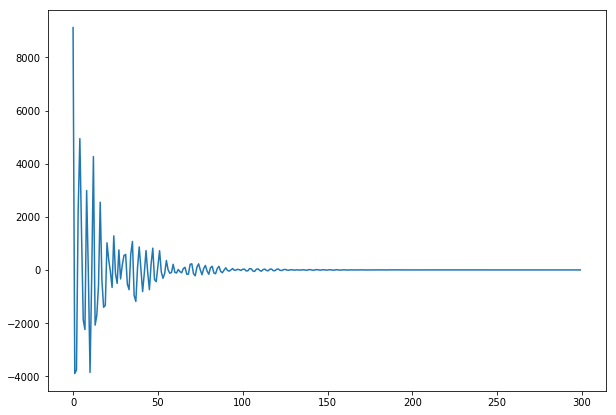

In [656]:
plt.plot(pred);